In [1]:
# coding:utf8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn import datasets
from sklearn.cluster import KMeans

from mydatools.plot import plot_classifier_paras

%matplotlib inline

In [2]:
def Gaussian(y, mu, sigma):
    """
    y: (d, 1); mu: (d, 1); sigma: (d, d)
    """
    d = y.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    if sigma_det == 0:
        sigma_det = np.linalg.det(sigma + np.eye(d)*0.01)
        sigma_inv = np.linalg.inv(sigma + np.eye(d)*0.01)
    sub = y - mu
    exponent = -0.5 * sub.T.dot(sigma_inv).dot(sub)
    coef = 1 / np.sqrt(np.power(2*np.pi, d) * sigma_det)
    gaussian = coef * np.exp(exponent)
    return gaussian

In [3]:
class GMM():
    def __init__(self, n_components=1, max_iter=100, init_params='kmeans'):
        self.n_components = n_components
        self.max_iter = max_iter
        self.init_params = init_params

    def fit(self, X):
        X = np.array(X).copy()
        m = X.shape[0]
        n = X.shape[1]
        K = self.n_components
        
        # init parameters
        if self.init_params == 'kmeans':
            mu = KMeans(K).fit(X).cluster_centers_[:,:,np.newaxis]
        elif self.init_params == 'random':
            mu = X[:K, :, np.newaxis]
        else:
            raise ValueError('init_params error')
        self.the_init_mu = mu[:,:,0].copy()
        sigma = np.tile(np.cov(X.T), (K,1,1))
        alpha = np.ones([1, K]) / K
        loglikehood = None
        
        for cur_iter in range(self.max_iter):
            # 求P(z\in\gamma|y, \theta)
            G = np.zeros([m, K])
            for j in range(m):
                x = X[j].reshape(-1, 1)
                for k in range(K):
                    G[j][k] = Gaussian(x, mu[k], sigma[k])
            P_yz = G * alpha # P(y, z\in\gamma| \theta)
            P = P_yz / P_yz.sum(axis=-1, keepdims=True)
            
#             # loglikehood
#             new_loglikehood = np.sum(np.log(P_yz))
#             if loglikehood is not None and abs(new_loglikehood - loglikehood) < 0.01:
#                 break
#             loglikehood = new_loglikehood
            
            # update parameters
            P_sum = P.sum(axis=0, keepdims=True)
            alpha = P_sum / m
            for k in range(K):
                mu[k] = 0
                for j in range(m):
                    mu[k] += P[j, k] * X[j].reshape(-1,1)
#                 mu[k] = X.T.dot(P[:, k:k+1])
                mu[k] = mu[k] / P_sum[0, k]
                
                sigma[k] = 0
                for j in range(m):
                    sub = X[j].reshape(-1,1) - mu[k]
                    sigma[k] += P[j,k] * sub.dot(sub.T)
                sigma[k] = sigma[k] / P_sum[0, k]
                
        self._alpha = alpha
        self._mu = mu
        self._sigma = sigma
        
    def cluster_centers(self):
        return self._mu[:,:,0]
    
    def predict(self, X):
        m = X.shape[0]
        K = self.n_components
        
        alpha = self._alpha
        mu = self._mu
        sigma = self._sigma
        
        G = np.zeros([m, K])
        for j in range(m):
            x = X[j].reshape(-1, 1)
            for k in range(K):
                G[j][k] = Gaussian(x, mu[k], sigma[k])
        P_yz = G * alpha
        
        return P_yz.argmax(axis=-1)
            

## 尝试感想

试了很多次，随机生成blobs

GMM对初始值特别敏感，最好还是用kmeans初始化，否则效果挺差的

因为高斯分布可以是椭圆状的，所以有时候初始值不好，会让某些类是细长的，
而kmeans倾向于更近的（也就是圆形的）

In [4]:
# np.random.seed(0)
X_train, y_train = datasets.make_blobs(200)

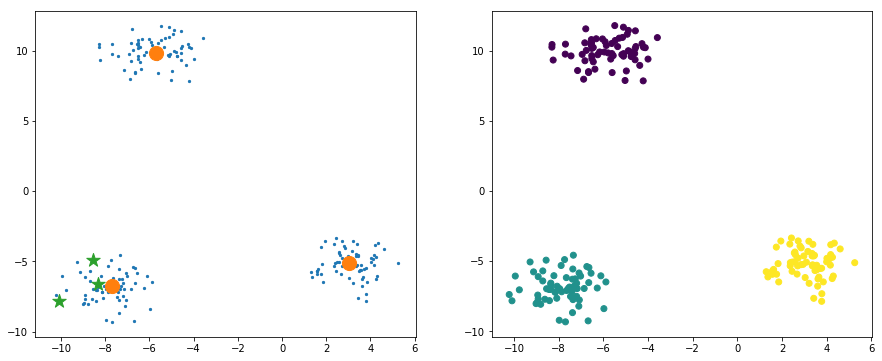

In [5]:
model = GMM(n_components=3, max_iter=100, init_params='random')
model.fit(X_train)
centers = model.cluster_centers()
y = model.predict(X_train)

fig = plt.figure(figsize=(15,6))

plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], s=5)
plt.scatter(centers[:, 0], centers[:, 1], s=200)
plt.scatter(model.the_init_mu[:, 0], model.the_init_mu[:, 1], s=200, marker='*')

plt.subplot(122)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y)
